# DLM feature engineering

An explorative approach to find out which input variables (features) have most impact on prediction of NO2 levels when using a simple learning model.

In [4]:
%reload_ext watermark
%watermark -a 'Johannes la Poutré' -v -p pandas,numpy,matplotlib,seaborn,sklearn,plotly

Johannes la Poutré 

CPython 3.6.3
IPython 6.2.1

pandas 0.21.0
numpy 1.13.3
matplotlib 2.1.0
seaborn 0.8.1
sklearn 0.19.1
plotly 2.2.1


In [239]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

In [240]:
# Learning models
from sklearn.feature_selection import RFE, f_regression
from sklearn.linear_model import (LinearRegression, Ridge, Lasso, RandomizedLasso)
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split

In [7]:
from subprocess import check_output
print(check_output(["ls", "../input/uitwisseling"]).decode("utf8"))

CBSopzet.zip
EindhovenMeteoz0p8.txt
LMLStat-236-237-247.csv
LinkNSLtoAireasLML
combineLinePoints.zip
combineLinePointsCleaned.zip
dataframe2_10u5-head100.csv
dataframe2_10u55.csv
dataframe2_14u12-head100.csv
dataframe2_14u12.csv
dataframe_11u13.csv
dataframe_13u48.csv
dataframe_15u42.csv
dataframe_16u32-random100.csv
dataframe_16u32.csv
head.csv
location_shift.xlsx
station16_NO2_jan.csv
station35_NO2_jan.csv
toelichtingSvR.txt



In [241]:
BASEDIR = '../input/uitwisseling'
INPUT = 'dataframe2_14u12'
# Data is interpreted inconsitently, use low_memory=False or specify dtypes
raw_df = pd.read_csv(BASEDIR + '/' + INPUT + '.csv', delimiter=',', low_memory=False)


In [242]:
# Station ID is mixed type (int, str)
# Convert stn_ID to str
raw_df['stn_ID'] = raw_df['stn_ID'].astype('str')


In [243]:
# get rid of unnamed row numbers column
raw_df.drop(raw_df.columns[0],axis=1, inplace=True)

In [11]:
# # Export sub-selection for just one station
# st16 = raw_df[(raw_df.stn_ID == '35') & (raw_df.dateTime < '2016-02-01')][['dateTime', 'NO2']].copy()
# # ['dateTime', 'NO2'].copy()
# st16.reset_index(drop=True, inplace=True)
# st16.to_csv(BASEDIR + "/station35_NO2_jan.csv")

# Correlations matrix

This matrix shows the correlation beteen almost all input variables which are available.

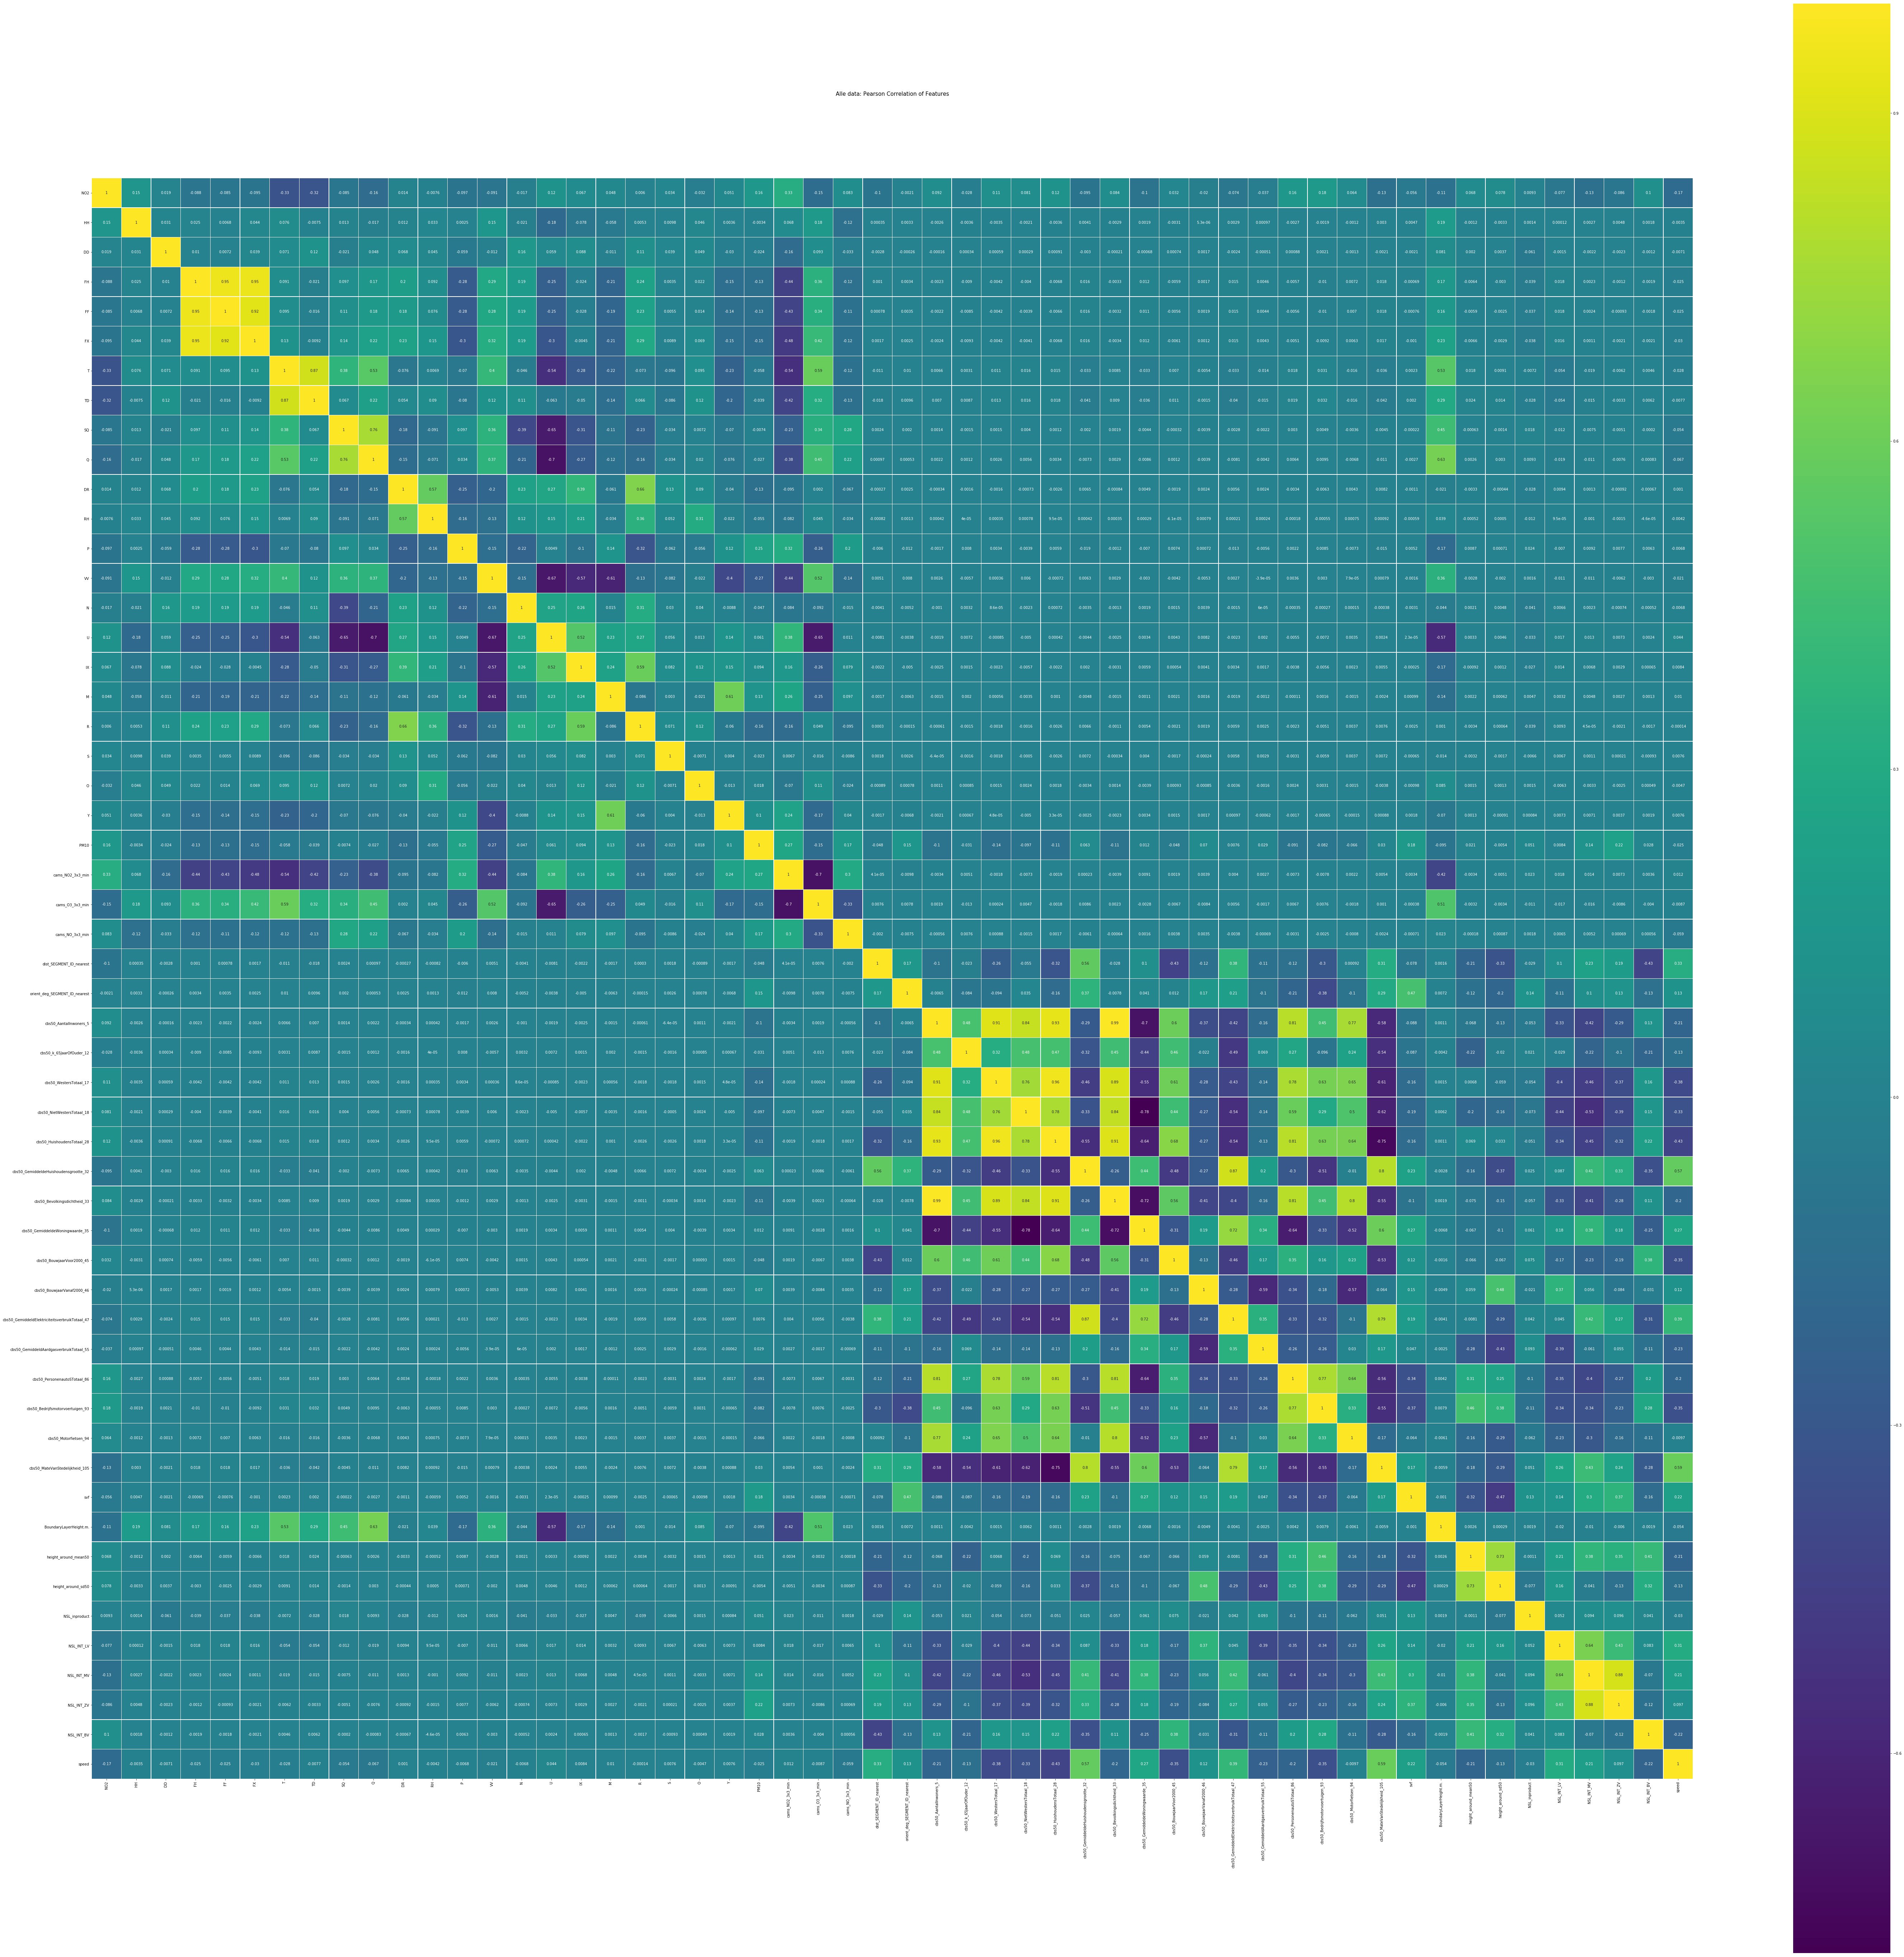

In [12]:
col_select = ['stn_ID', 'dateTime', 'NO2', 'HH', 'DD', 'FH', 'FF', 'FX', 'T', 'TD', 'SQ', 'Q', 'DR', 'RH', 'P', 'VV', 'N', 'U', 'IX', 'M', 'R', 'S', 'O', 'Y', 'PM10', 
              'cams_NO2_3x3_min', 'cams_O3_3x3_min', 'cams_NO_3x3_min', 'dist_SEGMENT_ID_nearest', 'orient_deg_SEGMENT_ID_nearest', 
              'cbs50_AantalInwoners_5', 'cbs50_k_65JaarOfOuder_12', 'cbs50_WestersTotaal_17', 
              'cbs50_NietWestersTotaal_18', 'cbs50_HuishoudensTotaal_28', 'cbs50_GemiddeldeHuishoudensgrootte_32', 
              'cbs50_Bevolkingsdichtheid_33', 'cbs50_GemiddeldeWoningwaarde_35', 'cbs50_BouwjaarVoor2000_45', 
              'cbs50_BouwjaarVanaf2000_46', 'cbs50_GemiddeldElektriciteitsverbruikTotaal_47', 
              'cbs50_GemiddeldAardgasverbruikTotaal_55', 'cbs50_PersonenautoSTotaal_86', 
              'cbs50_Bedrijfsmotorvoertuigen_93', 'cbs50_Motorfietsen_94', 'cbs50_MateVanStedelijkheid_105', 
              'svf', 'BoundaryLayerHeight.m.', 'height_around_mean50', 'height_around_sd50',               
              'NSL_inproduct', 'NSL_INT_LV', 'NSL_INT_MV', 'NSL_INT_ZV', 'NSL_INT_BV', 'speed']
data2 = raw_df[col_select].copy()

numeric_df = data2.select_dtypes([np.number])

colormap = plt.cm.viridis
plt.figure(figsize=(100,100))
plt.title('Alle data: Pearson Correlation of Features', y=1.05, size=15)
plot = sns.heatmap(numeric_df.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)


## conclusions

Many variables are not very strongly correlated, but there are some exceptions.
The corelation range varies between -0.75 and ~ 1.0. We see the strongest correlations where we already can expect variables to be related such as 
- demographics numbers (totals and fractions like # of inhabitatnts which is pretty strongly corrrelated with the # of inhabitants over 65 years age).
- climatic variables which are physically related (temperature and rel. humidity in absense of strong winds)
- building heights, averages and standard deviations

A separate class forms hour of the day which is strongly correlated with human activity but as this is not visible as such by numeric value of houw block (we will process this as a categorical variable later on)


In [17]:
# save the heatmap to a high resolution picture on disk
figure = plot.get_figure()    
figure.savefig(INPUT + '-heatmap.png')

# Limited feature selection

Let's start with a limited feature selection to start the exploration.
This selection is plotted in the following correlation matrix.

In [244]:
col_select = ['NO2', 'T', 'FH', 'TD', 'Q', 'DR', 'RH', 'P', 'VV', 'N', 'U', 'BoundaryLayerHeight.m.', 'speed']
data = raw_df[col_select].copy()

## correlations matrix

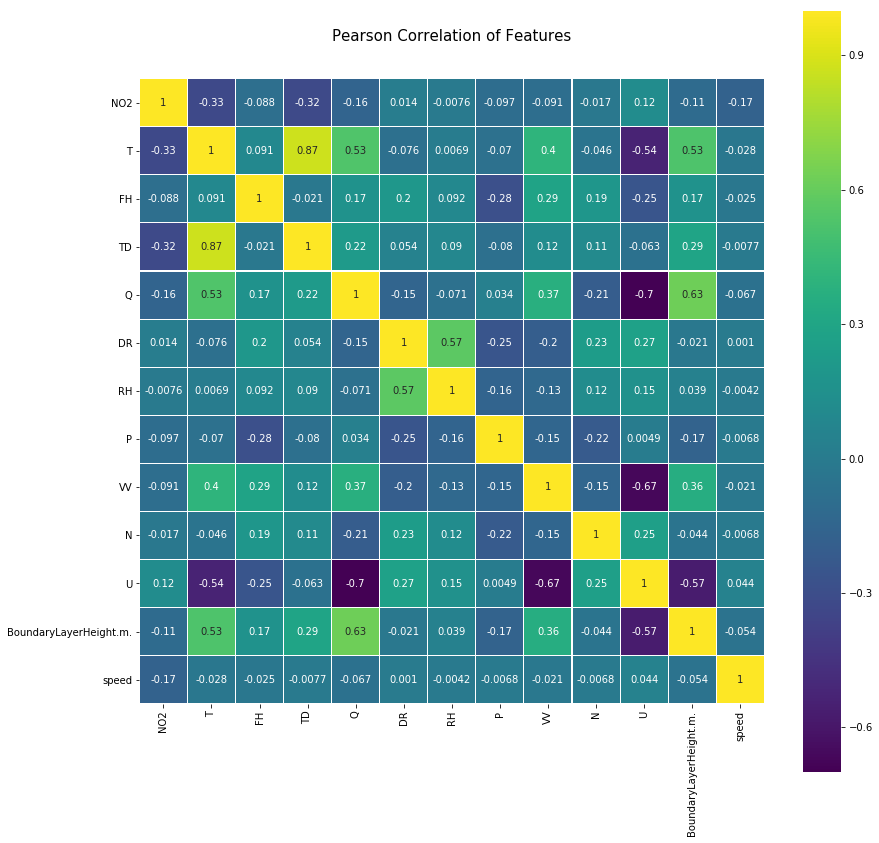

In [245]:
colormap = plt.cm.viridis
plt.figure(figsize=(14,14))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(data.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

In [246]:
# print('Rows: ' + str(data.index.size))
data = data.dropna(axis=0) # remove rows with any NaNs in it
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167090 entries, 0 to 168484
Data columns (total 13 columns):
NO2                       167090 non-null float64
T                         167090 non-null int64
FH                        167090 non-null int64
TD                        167090 non-null int64
Q                         167090 non-null int64
DR                        167090 non-null int64
RH                        167090 non-null int64
P                         167090 non-null int64
VV                        167090 non-null float64
N                         167090 non-null int64
U                         167090 non-null int64
BoundaryLayerHeight.m.    167090 non-null float64
speed                     167090 non-null float64
dtypes: float64(4), int64(9)
memory usage: 17.8 MB


## Pairplots

150


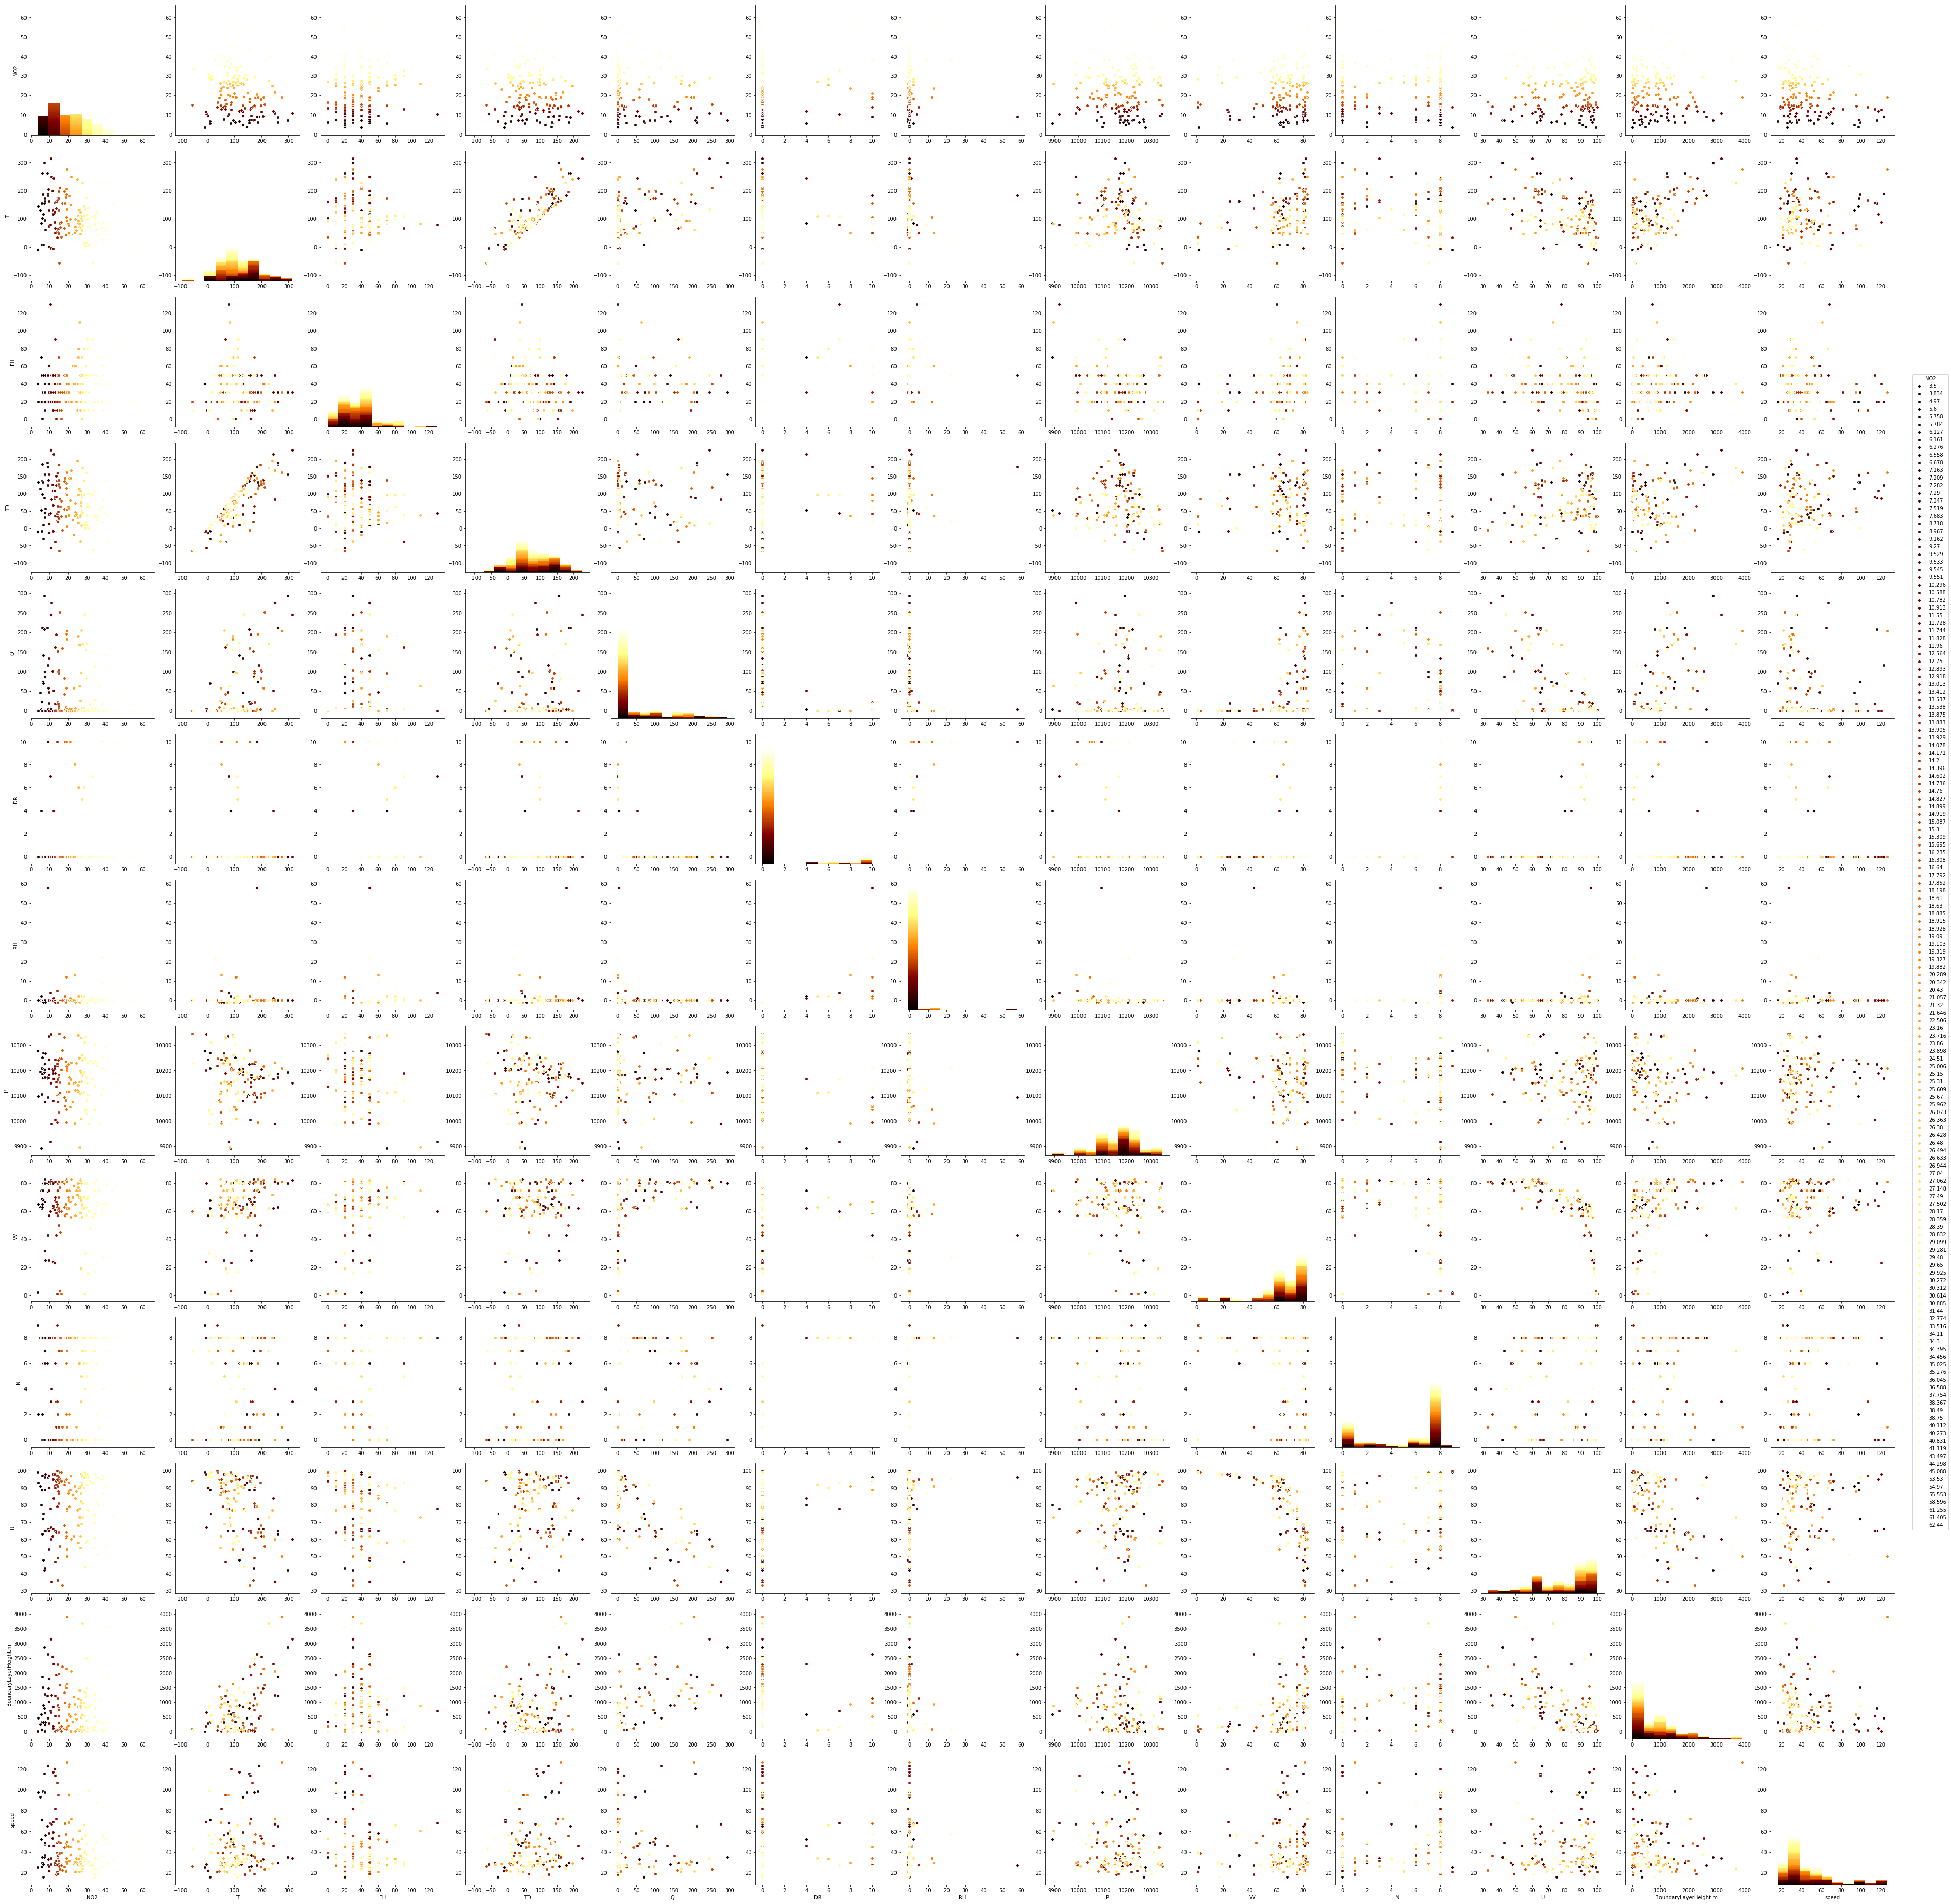

In [248]:
# Use a limited random sample as this requires much processing power
chosen_idx = np.random.choice(data.index.size - 1, replace=False, size=150)
df_trimmed = data.iloc[chosen_idx]
df_trimmed.reset_index(drop=True, inplace=True)
print(df_trimmed.index.size)


g = sns.pairplot(df_trimmed, hue='NO2', palette='afmhot',size=4)


In [250]:
# save the pairplot to a high resolution picture on disk
g.savefig(INPUT + '-pairplot.png')

# Recursive Feature Elimination ( RFE )

Recursive Feature Elimination or RFE uses a model (eg. linear Regression or SVM) to select either the best or worst-performing feature, and then excludes this feature. The whole process is then iterated until all features in the dataset are used up (or up to a user-defined limit). Sklearn provides a RFE function via the sklearn.feature_selection call and we will use this along with a simple linear regression model for our ranking search.

We use the data selected in the previous step.

In [141]:
# Utility function to convert integer categories to dummy variables
# needed because sklearn random forest only works with floats as input values
# needs features HH and dateTime
# perform some cleanup and drop int values which are replaced
# by category dummies
def convert_categories(data):
    
    # Convert string representation of datetime to real datetime
    data.dateTime = pd.to_datetime(data.dateTime)
    
    # remove rows with any NaNs in it
    data = data.dropna(axis=0)
    
    # get day of week (0 = Mon, 6 = Sun)
    dow = data.dateTime.dt.dayofweek;
    dow = dow.astype('int', copy=True, errors='ignore')

    # Convert day of week to dummy values
    dow_dummies = pd.get_dummies(dow, prefix='dw')
#     data = data.merge(dow_dummies, how='outer', left_index=True, right_index=True)

    # remove rows with any NaNs in it
    data = data.dropna(axis=0)

    # data['HH'] = data['HH'].astype('category')
    # use dummies instead of numerical HH data
    hr_dummies = pd.get_dummies(data.HH, prefix='hr')
    data = data.merge(hr_dummies, how='outer', left_index=True, right_index=True)

    # Drop columns we don't want in our features list
    data = data.drop(columns=['HH', 'dateTime'])

    return data


In [142]:
col_select = ['dateTime', 'HH', 'NO2', 'T', 'FH', 'TD', 'Q', 'DR', 'RH', 'P', 'VV', 'N', 'U', 'BoundaryLayerHeight.m.', 'speed']
data = raw_df[col_select].copy()

data = convert_categories(data)
data.head()

,NO2,T,FH,TD,Q,DR,RH,P,VV,N,...,hr_15,hr_16,hr_17,hr_18,hr_19,hr_20,hr_21,hr_22,hr_23,hr_24
0,17.534,63,50,35,0,0,0,10220,64.0,2,...,0,0,0,0,0,0,0,0,0,1
1,17.464,66,40,38,0,0,0,10224,65.0,8,...,0,0,0,0,0,0,0,0,0,0
2,17.540,70,40,43,0,0,-1,10228,68.0,8,...,0,0,0,0,0,0,0,0,0,0
3,17.510,59,40,46,0,0,-1,10232,65.0,2,...,0,0,0,0,0,0,0,0,0,0
4,17.353,42,20,36,0,0,0,10237,61.0,4,...,0,0,0,0,0,0,0,0,0,0


In [144]:
# First extract the target variable (which is NO2)
Y = data.NO2.values
# Drop NO2 from the dataframe and create a matrix out of the house data
data = data.drop(['NO2'], axis=1)

X = data.as_matrix()

# Store the column/feature names into a list "colnames"
colnames = data.columns

In [145]:
# Define dictionary to store our rankings
ranks = {}
# Create our function which stores the feature rankings to the ranks dictionary
def ranking(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x,2), ranks)
    return dict(zip(names, ranks))

In [146]:
# Construct our Linear Regression model
lr = LinearRegression(normalize=True)
lr.fit(X,Y)
#stop the search when only the last feature is left
rfe = RFE(lr, n_features_to_select=1, verbose=2)
rfe.fit(X,Y)
ranks["RFE"] = ranking(list(map(float, rfe.ranking_)), colnames, order=-1)

Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 fe

## Linear Model Feature Ranking

In [147]:
# Using Linear Regression
lr = LinearRegression(normalize=False)
lr.fit(X,Y)
ranks["LinReg"] = ranking(np.abs(lr.coef_), colnames)

# Using Ridge 
ridge = Ridge(alpha = 7)
ridge.fit(X,Y)
ranks['Ridge'] = ranking(np.abs(ridge.coef_), colnames)

# Using Lasso
lasso = Lasso(alpha=.05)
lasso.fit(X, Y)
ranks["Lasso"] = ranking(np.abs(lasso.coef_), colnames)

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.



## Random Forest feature ranking

In [148]:
rf = RandomForestRegressor(n_jobs=-1, n_estimators=50, verbose=2)
rf.fit(X,Y)
ranks["RF"] = ranking(rf.feature_importances_, colnames)

building tree 1 of 50building tree 2 of 50building tree 3 of 50building tree 4 of 50building tree 5 of 50building tree 6 of 50building tree 7 of 50building tree 8 of 50







building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.9s


building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   15.7s finished


## The Feature Ranking Matrix

We combine the scores from the various methods above and output it in a matrix form for convenient viewing as such:

In [149]:
# Create empty dictionary to store the mean value calculated from all the scores
r = {}
for name in colnames:
    r[name] = round(np.mean([ranks[method][name] 
                             for method in ranks.keys()]), 2)
 
methods = sorted(ranks.keys())
ranks["Mean"] = r
methods.append("Mean")
 
print("\t%s" % "\t".join(methods))
for name in colnames:
    print("%s\t%s" % (name, "\t".join(map(str, 
                         [ranks[method][name] for method in methods]))))

	Lasso	LinReg	RF	RFE	Ridge	Mean
T	0.01	0.01	0.59	0.21	0.01	0.17
FH	0.01	0.01	0.17	0.17	0.01	0.07
TD	0.02	0.02	0.21	0.24	0.02	0.1
Q	0.0	0.0	0.12	0.1	0.0	0.04
DR	0.01	0.02	0.01	0.07	0.02	0.03
RH	0.01	0.01	0.02	0.14	0.01	0.04
P	0.0	0.0	0.35	0.05	0.0	0.08
VV	0.0	0.0	0.11	0.02	0.0	0.03
N	0.02	0.02	0.06	0.12	0.02	0.05
U	0.03	0.04	0.13	0.26	0.04	0.1
BoundaryLayerHeight.m.	0.0	0.0	0.39	0.0	0.0	0.08
speed	0.01	0.01	1.0	0.19	0.01	0.24
dw_0	0.11	0.01	0.02	0.33	0.01	0.1
dw_1	0.0	0.16	0.03	0.4	0.17	0.15
dw_2	0.04	0.22	0.02	0.43	0.22	0.19
dw_3	0.01	0.18	0.03	0.38	0.18	0.16
dw_4	0.0	0.15	0.02	0.36	0.15	0.14
dw_5	0.37	0.24	0.03	0.31	0.24	0.24
dw_6	0.65	0.48	0.07	0.29	0.48	0.39
hr_1	0.72	0.75	0.0	0.93	0.75	0.63
hr_2	0.92	0.93	0.01	0.95	0.93	0.75
hr_3	1.0	1.0	0.01	1.0	1.0	0.8
hr_4	0.98	0.98	0.01	0.98	0.98	0.79
hr_5	0.73	0.75	0.01	0.9	0.75	0.63
hr_6	0.3	0.34	0.0	0.74	0.34	0.34
hr_7	0.0	0.03	0.01	0.6	0.03	0.13
hr_8	0.0	0.19	0.01	0.64	0.19	0.21
hr_9	0.0	0.23	0.0	0.71	0.23	0.23
hr_10	0.0	0.29	0.0	0.81	0.29	

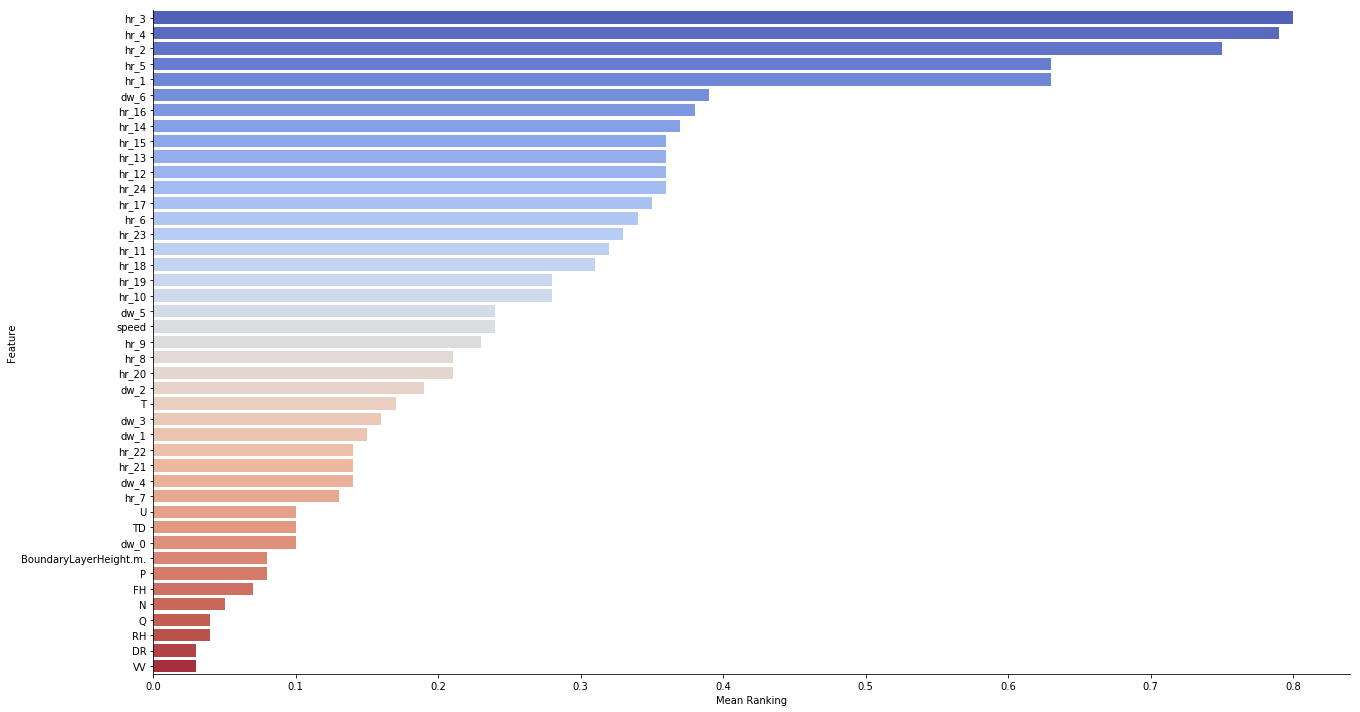

In [150]:
# Put the mean scores into a Pandas dataframe
meanplot = pd.DataFrame(list(r.items()), columns= ['Feature','Mean Ranking'])

# Sort the dataframe
meanplot = meanplot.sort_values('Mean Ranking', ascending=False)

# Plot the ranking of the features
sns.factorplot(x="Mean Ranking", y="Feature", data = meanplot, 
               kind="bar", size=10, aspect=1.9, palette='coolwarm')

## Conclusion

From the feature ranking it looks like time of day and day of week are the most important predicting features, followed by local traffic speed and only then followed by weather conditions.

# Simple model test

Test predictions using a basic [Random Forest Regression](https://en.wikipedia.org/wiki/Random_forest) model

We will use data from a single measurememt station and a limited time period because of data inconsistencies between stations and observed drift over time.

## First run based on selected predictors

In [181]:
STATION_ID = 'NL10237'

# col_select = ['HH', 'NO2', 'T', 'FH', 'TD', 'DR', 'P', 'N', 'U', 'BoundaryLayerHeight.m.']
col_select = ['dateTime', 'HH', 'NO2', 'T', 'FH', 'TD', 'Q', 'DR', 'RH', 'P', 'VV', 'N', 'U', 'BoundaryLayerHeight.m.', 'speed']

data1 = raw_df[(raw_df.stn_ID == STATION_ID) &
               (raw_df.dateTime < '2016-04-01')
              ][col_select].copy()

# Convert the hour block values to categorial data; 
# sklearn dowsn't have a feature for working with categorial data so we 
# will be using 24 dummy variables instead


data1 = convert_categories(data1)
data1.shape

(1907, 44)

In [182]:
# train, test = train_test_split(data, test_size=0.2)

y = data1.NO2 # define the target variable (dependent variable) as y
X_train, X_test, y_train, y_test = train_test_split(data1, y, test_size=0.2)

X_train = X_train.drop(['NO2'], axis=1)
X_test = X_test.drop(['NO2'], axis=1)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
X_train.head()

(1525, 43) (1525,)
(382, 43) (382,)


,T,FH,TD,Q,DR,RH,P,VV,N,U,...,hr_15,hr_16,hr_17,hr_18,hr_19,hr_20,hr_21,hr_22,hr_23,hr_24
153009,-22,10,-23,0,0,0,10141,8.0,8,99,...,0,0,0,0,0,0,0,0,0,0
152675,37,40,27,0,0,0,10107,65.0,8,93,...,0,0,0,0,0,0,0,0,0,0
152825,31,50,-23,95,0,0,10251,79.0,0,68,...,0,0,0,0,0,0,0,0,0,0
152062,74,40,22,95,0,0,10263,75.0,1,70,...,0,0,0,0,0,0,0,0,0,0
152717,-5,10,-13,0,0,0,10154,65.0,0,94,...,0,0,0,0,1,0,0,0,0,0


In [183]:
rf = RandomForestRegressor(n_jobs=-1, n_estimators=90, verbose=1)
rf.fit(X_train, y_train)
predictions = rf.predict(X_test)

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  90 out of  90 | elapsed:    0.0s finished


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  90 out of  90 | elapsed:    0.0s finished


Text(0.5,1,'RandomForestRegressor Prediction of NO2 for Station ID NL10237 in Q1 2016\nScore based on limited variables = 0.784040740346')

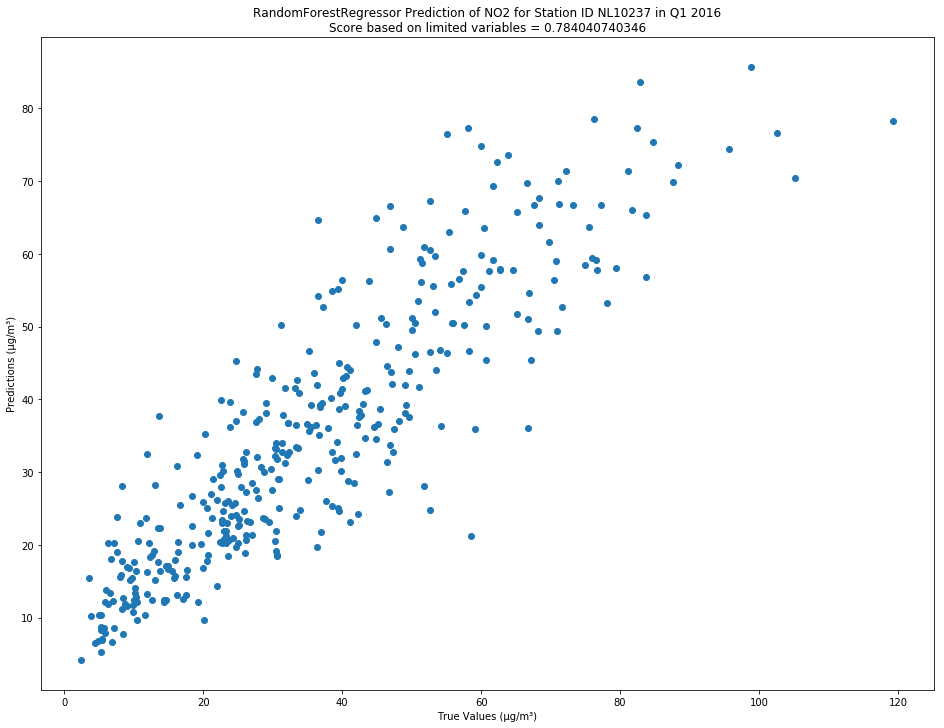

In [184]:
# Calculate model score
rf_score = rf.score(X_test, y_test)

# Plot predictions
plt.figure(figsize=(16,12))
plt.scatter(y_test, predictions)
plt.xlabel('True Values (μg/m³)')
plt.ylabel('Predictions (μg/m³)')
plt.title("RandomForestRegressor Prediction of NO2 for Station ID " + STATION_ID +
          " in Q1 2016\nScore based on limited variables = " + str(rf_score))


## Using (almost) all numeric values

Using a huge selection of all available numeric data omitting those which are too much correlated.

In [215]:
# Try with all numerical variables
col_select = ['stn_ID', 'dateTime', 'NO2', 'HH', 'DD', 'FH', 'FF', 'FX', 'T', 'TD', 'SQ', 'Q', 'DR', 'RH', 'P', 'VV', 'N', 'U', 'IX', 'M', 'R', 'S', 'O', 'Y', 'PM10', 
              'cams_NO2_3x3_min', 'cams_O3_3x3_min', 'cams_NO_3x3_min', 'dist_SEGMENT_ID_nearest', 'orient_deg_SEGMENT_ID_nearest', 
              'cbs50_AantalInwoners_5', 'cbs50_k_65JaarOfOuder_12', 'cbs50_WestersTotaal_17', 
              'cbs50_NietWestersTotaal_18', 'cbs50_HuishoudensTotaal_28', 'cbs50_GemiddeldeHuishoudensgrootte_32', 
              'cbs50_Bevolkingsdichtheid_33', 'cbs50_GemiddeldeWoningwaarde_35', 'cbs50_BouwjaarVoor2000_45', 
              'cbs50_BouwjaarVanaf2000_46', 'cbs50_GemiddeldElektriciteitsverbruikTotaal_47', 
              'cbs50_GemiddeldAardgasverbruikTotaal_55', 'cbs50_PersonenautoSTotaal_86', 
              'cbs50_Bedrijfsmotorvoertuigen_93', 'cbs50_Motorfietsen_94', 'cbs50_MateVanStedelijkheid_105', 
              'svf', 'BoundaryLayerHeight.m.', 'height_around_mean50', 'height_around_sd50', 
              'NSL_inproduct', 'NSL_INT_LV', 'NSL_INT_MV', 'NSL_INT_ZV', 'NSL_INT_BV', 'speed']
data_all = raw_df[col_select].copy()

# convert to datetime type
data_all.dateTime = pd.to_datetime(data_all.dateTime)
print(data_all.stn_ID.unique())

['12' '13' '14' '16' '19' '21' '22' '23' '26' '29' '3' '30' '34' '35' '36'
 '4' '5' '6' '8' 'NL10236' 'NL10237' 'NL10247']


In [217]:
# select relevant columns, types
data2 = data_all[((data_all.stn_ID == 'NL10236') |
              (data_all.stn_ID == 'NL10237') |
              (data_all.stn_ID == 'NL10247')) &
               (data_all.dateTime < '2017-01-01')
              ].select_dtypes(include=[np.number, np.datetime64])

In [218]:
# data2 = data2.select_dtypes(include=[np.number, np.datetime64])

In [219]:
data2 = convert_categories(data2)

data2.shape

(20248, 84)

In [220]:
data2.head()

,NO2,DD,FH,FF,FX,T,TD,SQ,Q,DR,...,hr_15,hr_16,hr_17,hr_18,hr_19,hr_20,hr_21,hr_22,hr_23,hr_24
143863,57.64,990,10,10,10,-36,-43,0,0,0,...,0,0,0,0,0,0,0,0,0,1
143865,55.13,0,0,0,10,-42,-44,0,0,0,...,0,0,0,0,0,0,0,0,0,0
143866,47.61,0,0,0,10,-46,-48,0,0,0,...,0,0,0,0,0,0,0,0,0,0
143867,52.55,0,0,0,10,-50,-52,0,0,0,...,0,0,0,0,0,0,0,0,0,0
143868,46.27,250,10,10,10,-54,-56,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [221]:
# Select training / test data
y = data2.NO2 # define the target variable (dependent variable) as y
X_train, X_test, y_train, y_test = train_test_split(data2, y, test_size=0.2)

X_train = X_train.drop(['NO2'], axis=1)
X_test = X_test.drop(['NO2'], axis=1)
# print(X_train.shape, y_train.shape)
# print(X_test.shape, y_test.shape)
X_train.head()

,DD,FH,FF,FX,T,TD,SQ,Q,DR,RH,...,hr_15,hr_16,hr_17,hr_18,hr_19,hr_20,hr_21,hr_22,hr_23,hr_24
158764,190,50,50,80,57,54,0,0,9,4,...,0,0,0,0,0,0,0,0,1,0
155077,220,30,40,50,156,142,0,59,0,-1,...,0,0,0,0,0,0,0,0,0,0
147722,210,20,20,50,200,145,9,163,0,0,...,0,0,0,0,0,0,0,0,0,0
156974,240,10,10,30,159,135,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
147720,220,10,10,20,156,144,2,45,0,0,...,0,0,0,0,0,0,0,0,0,0


In [222]:
rf = RandomForestRegressor(n_jobs=-1, n_estimators=90, verbose=1)
rf.fit(X_train, y_train)
predictions = rf.predict(X_test)

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    4.2s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  90 out of  90 | elapsed:    0.0s finished


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  90 out of  90 | elapsed:    0.0s finished


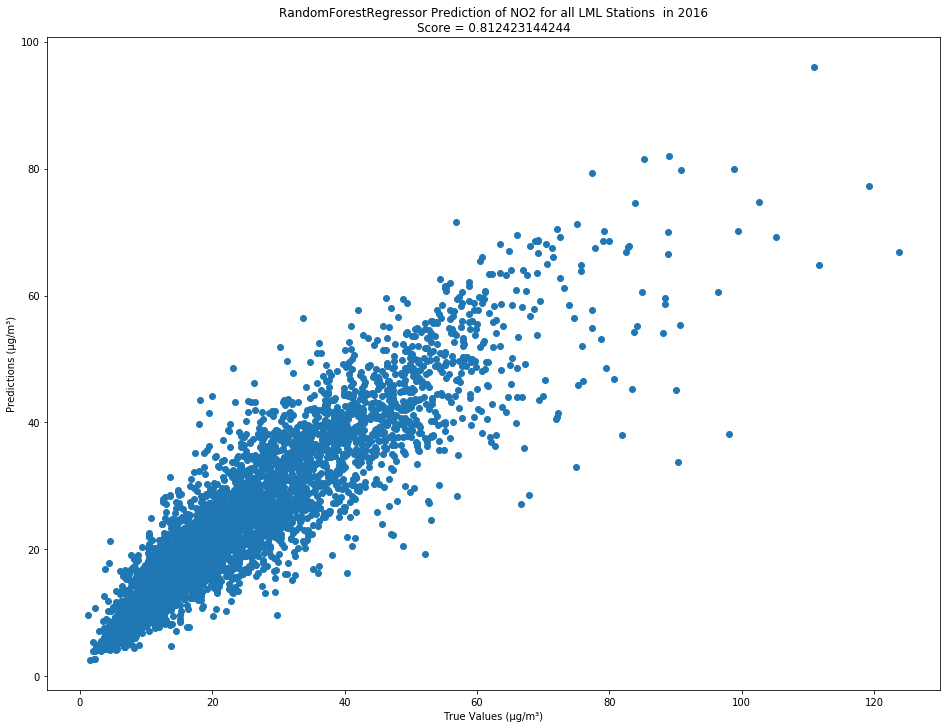

In [224]:
# Calculate model score
rf_score = rf.score(X_test, y_test)

# Plot predictions
plt.figure(figsize=(16,12))
plt.scatter(y_test, predictions)
plt.xlabel('True Values (μg/m³)')
plt.ylabel('Predictions (μg/m³)')
plt.title("RandomForestRegressor Prediction of NO2 for all LML Stations " +
          " in 2016\nScore = " + str(rf_score))
plt.savefig('LML-prediction-2016.png')
plt.show()


In [233]:
def run_regression(data_all, stn_ID):
    # select relevant columns, types
    data2 = data_all[(data_all.stn_ID == stn_ID) &
                     (data_all.dateTime < '2017-01-01')
                    ].select_dtypes(include=[np.number, np.datetime64])
    
    data2 = convert_categories(data2)
    
    # Select training / test data
    y = data2.NO2 # define the target variable (dependent variable) as y
    X_train, X_test, y_train, y_test = train_test_split(data2, y, test_size=0.2)

    X_train = X_train.drop(['NO2'], axis=1)
    X_test = X_test.drop(['NO2'], axis=1)

    rf = RandomForestRegressor(n_jobs=-1, n_estimators=90, verbose=1)
    rf.fit(X_train, y_train)
    predictions = rf.predict(X_test)
    
    # Calculate model score
    rf_score = rf.score(X_test, y_test)

    # Plot predictions
    plt.figure(figsize=(16,12))
    plt.scatter(y_test, predictions)
    plt.xlabel('True Values (μg/m³)')
    plt.ylabel('Predictions (μg/m³)')
    plt.title("RandomForestRegressor Prediction of NO2 for Station ID " + stn_ID +
              " in 2016\nScore based on limited variables = " + str(rf_score))
    plt.savefig(stn_ID + '-prediction-2016.png')

In [234]:
data_all.stn_ID.unique()

array(['12', '13', '14', '16', '19', '21', '22', '23', '26', '29', '3',
       '30', '34', '35', '36', '4', '5', '6', '8', 'NL10236', 'NL10237',
       'NL10247'], dtype=object)

In [237]:
stn_ids = ['12', '13', '14', '16', '19', '21', '22', '23', '26', '29', '3',
       '30', '34', '35', '36', '4', '5', '6', '8']
len(stn_ids)

# for stn_ID in (stn_ids):
#     run_regression(data_all, stn_ID)


19

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  90 out of  90 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  90 out of  90 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  90 out of  90 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  90 out of  90 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs

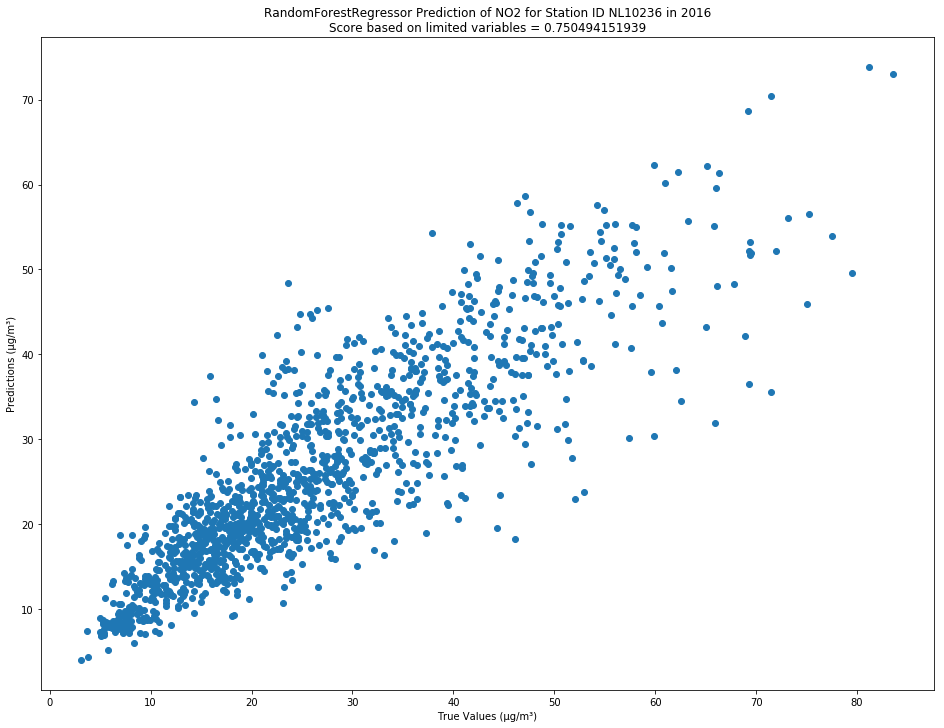

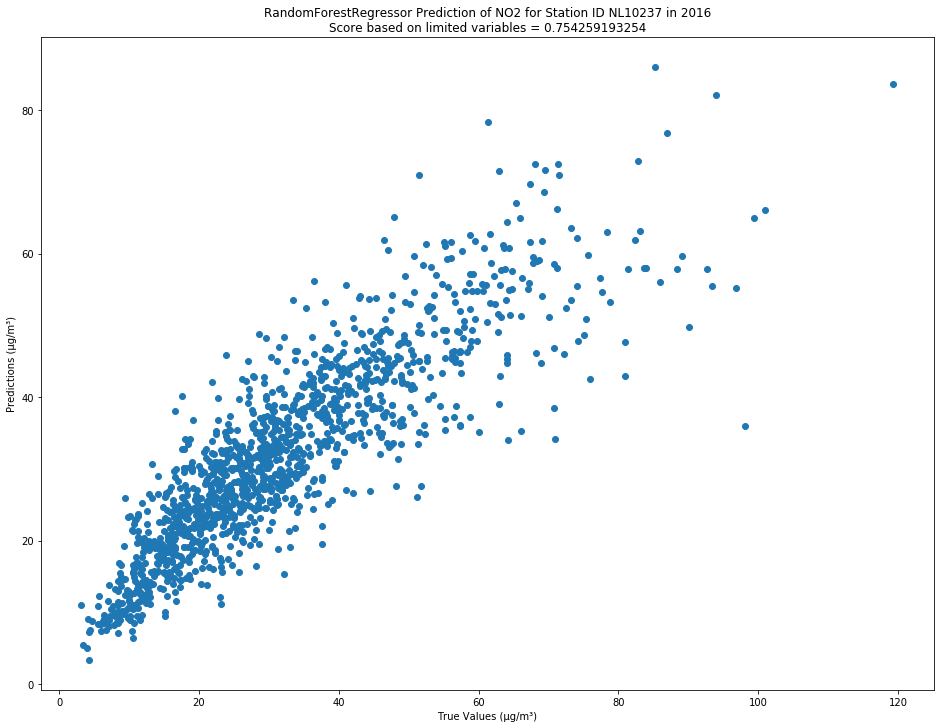

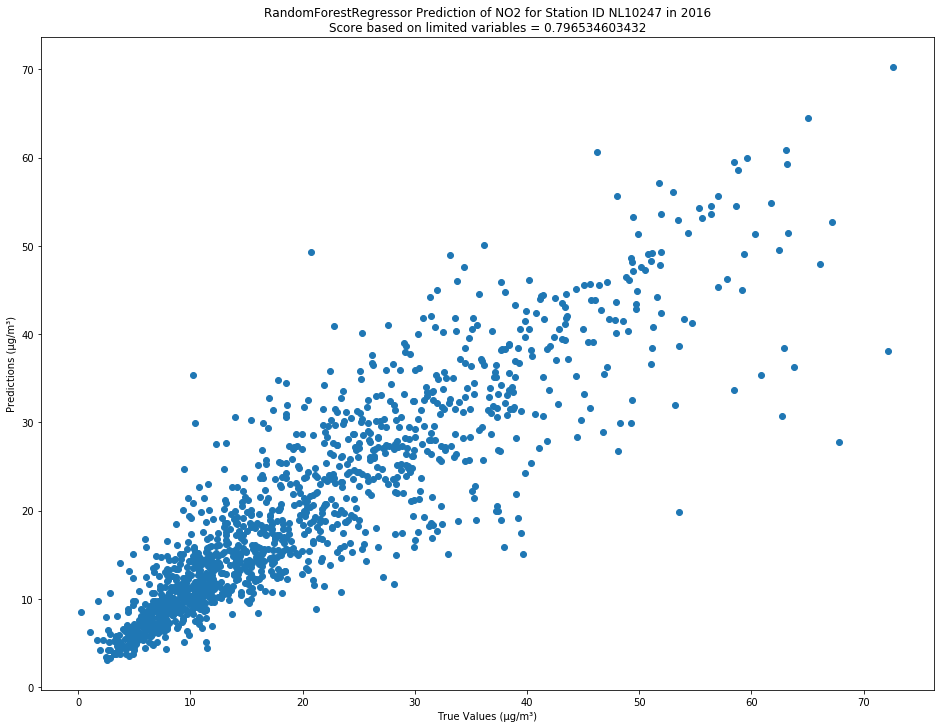

In [238]:
stn_ids = ['NL10236', 'NL10237', 'NL10247']

for stn_ID in (stn_ids):
    run_regression(data_all, stn_ID)
